In [1]:
import os
import random
import numpy as np
import tensorflow as tf

def seed_everything(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

seed_everything(42)  # Seed 고정

## 데이터 불러오기

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('../ssd_data/final_data/final_MB1.csv')
# 'index' 컬럼을 datetime 형태로 변환
data['index'] = pd.to_datetime(data['index'])

data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
0,2019-01-01,6653.0,100.0,0.0,97.0,12707.0,99.0,12.0,99.0,28.0,...,28.0,200.0,0.0,100.0,0.0,99.0,4.976439e+10,99.0,3.939800e+10,0.0
1,2019-01-02,6653.0,100.0,0.0,97.0,12731.0,99.0,12.0,99.0,28.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.034821e+10,99.0,3.956458e+10,0.0
2,2019-01-03,6653.0,100.0,0.0,97.0,12755.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.082254e+10,99.0,3.973763e+10,0.0
3,2019-01-04,6653.0,100.0,0.0,97.0,12779.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.121309e+10,99.0,3.990997e+10,0.0
4,2019-01-05,6653.0,100.0,0.0,97.0,12803.0,99.0,12.0,99.0,29.0,...,28.0,200.0,0.0,100.0,0.0,99.0,5.157860e+10,99.0,4.008257e+10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71551,2019-03-21,44338.0,99.0,2.0,96.0,16176.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.778025e+09,1.0
71552,2019-03-22,44338.0,99.0,2.0,96.0,16200.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.779657e+09,1.0
71553,2019-03-23,44338.0,99.0,2.0,96.0,16224.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.781085e+09,1.0
71554,2019-03-24,44338.0,99.0,2.0,96.0,16248.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.782419e+09,1.0


In [30]:
# 라벨이 1인 행을 필터링합니다.
selected_disk_model_1 = data[data['label'] == 1]

# 모델, disk_id, 그리고 날짜 순으로 정렬합니다.
selected_disk_model_1 = selected_disk_model_1.sort_values(by=['disk_id', 'index'])

# disk_id와 model 열만을 선택하여 새로운 데이터 프레임에 저장합니다.
selected_disk_model_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)

label_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)
label_1

,disk_id
0,470.0
1,476.0
2,531.0
3,601.0
4,609.0
...,...
237,43760.0
238,44325.0
239,44330.0
240,44335.0


In [31]:
import numpy as np
def create_sequences(data, window_size):
    X = []
    y = []

    # 각 disk_id에 대해 처리
    for disk_id in data['disk_id'].unique():
        disk_data = data[data['disk_id'] == disk_id].sort_values('index')  # index로 정렬
        disk_values = disk_data.drop(columns=['disk_id', 'index']).values  # 'disk_id'와 'index' 컬럼을 제외하고 numpy array로 변환

        # 이 disk_id에 대해 시퀀스 생성
        for i in range(len(disk_values) - window_size):
            X.append(disk_values[i:i + window_size, :-1])  # 마지막 차원은 특성(feature)을 의미합니다. 마지막 열('fail')을 제외합니다.
            y.append(disk_values[i + window_size -1, -1])  # 예를 들어 'fail' 상태가 마지막 특성일 경우입니다.

    return np.array(X), np.array(y)

## dataset 만들기

In [32]:
len(failure_disk_list)

242

In [33]:
disk_list = list(data['disk_id'].drop_duplicates())
failure_disk_list = list(label_1.values.squeeze())
healthy_disk_list = list(set(disk_list) - set(failure_disk_list))

In [34]:
import random
random.seed(42)

# 194개씩 랜덤하게 선택
healthy_disk_194 = random.sample(healthy_disk_list, 194)
failure_disk_194 = random.sample(failure_disk_list, 194)

print(len(healthy_disk_194))
print(len(failure_disk_194))

# 194개에서 155/39 개로 validation set 구축
healthy_disk_155 = random.sample(healthy_disk_194,155) #train set
healthy_disk_39 = list(set(healthy_disk_194) - set(healthy_disk_155)) #validation set

failure_disk_155 = random.sample(failure_disk_194, 155) #train set
failure_disk_39 = list(set(failure_disk_194) - set(failure_disk_155)) #validation set

print('train_healthy_count:', len(healthy_disk_155))
print('train_failure_count:', len(failure_disk_155))

print('val_healthy_count:', len(healthy_disk_39))
print('val_failure_count:',len(failure_disk_39))
# 48개씩 랜덤하게 선택
healthy_disk_48 = random.sample(list(set(healthy_disk_list) - set(healthy_disk_194)), 48)
failure_disk_48 = list(set(failure_disk_list) - set(failure_disk_194))

print('test_healthy_count:',len(healthy_disk_48))
print('test_healthy_count:',len(failure_disk_48))

194
194
train_healthy_count: 155
train_failure_count: 155
val_healthy_count: 39
val_failure_count: 39
test_healthy_count: 48
test_healthy_count: 48


In [35]:
H_disk_194 = data[data['disk_id'].isin(healthy_disk_194)]
F_disk_194 = data[data['disk_id'].isin(failure_disk_194)]

H_disk_155 = data[data['disk_id'].isin(healthy_disk_155)]
F_disk_155 = data[data['disk_id'].isin(failure_disk_155)]

H_disk_39 = data[data['disk_id'].isin(healthy_disk_39)]
F_disk_39 = data[data['disk_id'].isin(failure_disk_39)]

H_disk_48 = data[data['disk_id'].isin(healthy_disk_48)]
F_disk_48 = data[data['disk_id'].isin(failure_disk_48)]

# train set, validation set, test set 생성
final_train_set = pd.concat([H_disk_194,F_disk_194],ignore_index=True,axis=0) #validation set으로 최적의 epoch 찾은 후, 해당 epoch으로 다시 training 시킬 예정
train_set = pd.concat([H_disk_155,F_disk_155],ignore_index=True,axis=0)
val_set = pd.concat([H_disk_39,F_disk_39],ignore_index=True,axis=0)
test_set = pd.concat([H_disk_48,F_disk_48],ignore_index=True,axis=0)

In [36]:
# feature와 label 구분
final_X_train = final_train_set.drop(columns=['disk_id','index','label'])
X_train = train_set.drop(columns=['disk_id','index','label'])
X_val = val_set.drop(columns=['disk_id','index','label'])
X_test = test_set.drop(columns=['disk_id','index','label'])

final_y_train = final_train_set['label']
y_train = train_set['label']
y_val = val_set['label']
y_test = test_set['label']

## LSTM

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_val_scaled=scaler.transform(X_val)
X_test_scaled=scaler.transform(X_test)

# Assuming 'X_train' is the original DataFrame before scaling and its columns are to be preserved
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

train_scaled = pd.concat([train_set[['disk_id','index']],X_train_scaled_df, y_train], axis=1)
val_scaled = pd.concat([val_set[['disk_id','index']],X_val_scaled_df, y_val], axis=1)

In [93]:
window_size = 30 # 10일을 window로 설정합니다.
X_train_window, y_train_window = create_sequences(train_scaled, window_size)
X_val_window, y_val_window = create_sequences(val_scaled, window_size)
X_test_window, y_test_window = create_sequences(test_scaled, window_size)

print(X_train_window.shape)
print(X_val_window.shape)
print(X_test_window.shape)

print(y_train_window.shape)
print(y_val_window.shape)
print(y_test_window.shape)

(36698, 30, 32)
(9100, 30, 32)
(11238, 30, 32)
(36698,)
(9100,)
(11238,)


In [55]:
def LSTM_model(node):
    # LSTM 모델 정의
    model = Sequential()
    model.add(LSTM(node, activation='relu', input_shape=(30, 32)))  # n_features는 특성의 수
    model.add(Dense(32, kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])

    return model

In [56]:
from keras.callbacks import ModelCheckpoint

# ModelCheckpoint 객체 생성
checkpoint = ModelCheckpoint('best_model.h5',  # model filename
                             monitor='val_loss', # property to monitor
                             verbose=1, # verbosity - 0 or 1
                             save_best_only=True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 
model = LSTM_model(32)

# 학습
history = model.fit(X_train_window, y_train_window, 
                    validation_data=(X_val_window, y_val_window),
                    epochs=20, 
                    verbose=1,
                    batch_size=32,
                    callbacks=[checkpoint])  # checkpoint callback 사용

Epoch 1/20
1144/1147 [============================>.] - ETA: 0s - loss: 0.3525 - acc: 0.8834
Epoch 1: val_loss improved from inf to 0.34325, saving model to best_model.h5
1147/1147 [==============================] - 10s 8ms/step - loss: 0.3524 - acc: 0.8834 - val_loss: 0.3433 - val_acc: 0.8808
Epoch 2/20
  21/1147 [..............................] - ETA: 8s - loss: 0.3374 - acc: 0.8869

c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1143/1147 [============================>.] - ETA: 0s - loss: 0.3166 - acc: 0.8874
Epoch 2: val_loss improved from 0.34325 to 0.31920, saving model to best_model.h5
1147/1147 [==============================] - 9s 8ms/step - loss: 0.3166 - acc: 0.8873 - val_loss: 0.3192 - val_acc: 0.8719
Epoch 3/20
1143/1147 [============================>.] - ETA: 0s - loss: 0.2873 - acc: 0.8913
Epoch 3: val_loss improved from 0.31920 to 0.29407, saving model to best_model.h5
1147/1147 [==============================] - 9s 8ms/step - loss: 0.2871 - acc: 0.8914 - val_loss: 0.2941 - val_acc: 0.8718
Epoch 4/20
1143/1147 [============================>.] - ETA: 0s - loss: 0.2737 - acc: 0.8917
Epoch 4: val_loss did not improve from 0.29407
1147/1147 [==============================] - 9s 8ms/step - loss: 0.2739 - acc: 0.8917 - val_loss: 0.3020 - val_acc: 0.8718
Epoch 5/20
1147/1147 [==============================] - ETA: 0s - loss: 0.2844 - acc: 0.8906
Epoch 5: val_loss did not improve from 0.29407
1147/1147 [=

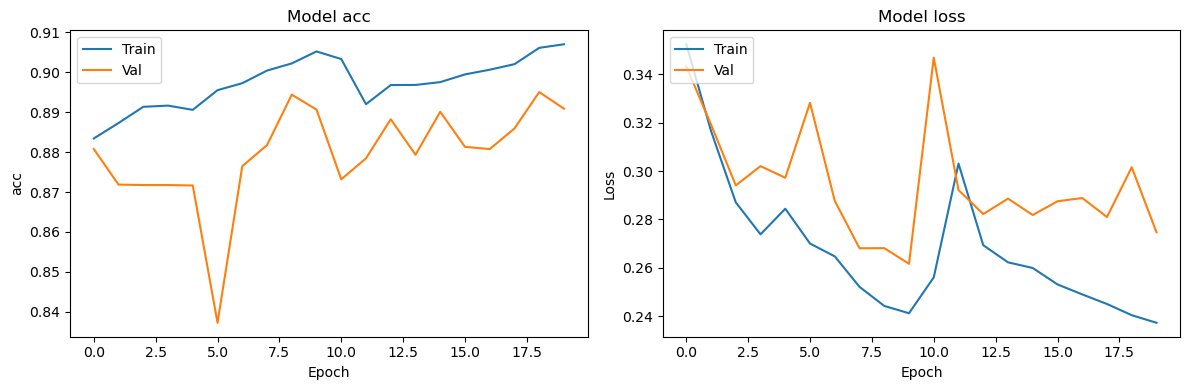

In [57]:
import matplotlib.pyplot as plt

# Plot training & validation acc values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

In [60]:
from keras.models import load_model

# LSTM 모델 정의
best_model = LSTM_model(32)

# 미리 저장한 모델 파일을 불러옵니다.
best_model.load_weights('best_model.h5')

# 모델을 사용하여 예측을 수행합니다.
best_model.evaluate(X_test_window,y_test_window)

352/352 [==============================] - 1s 3ms/step - loss: 0.3128 - acc: 0.8761


[0.31277021765708923, 0.8761345148086548]

In [61]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

352/352 [==============================] - 1s 3ms/step
Macro F1 Score: 0.6429279943903116


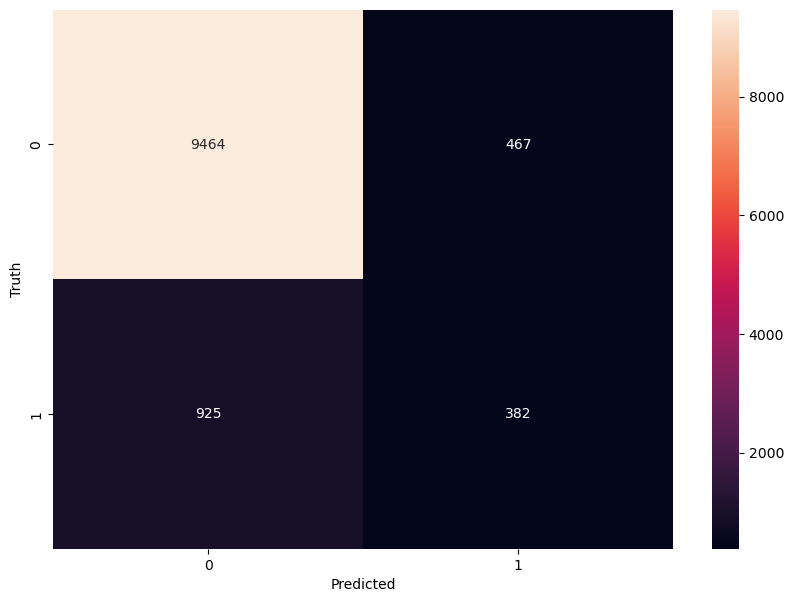

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [63]:
print(y_test_window.shape)

count_ones = np.count_nonzero(y_test_window == 1)

print("Number of ones in y_test_window:", count_ones)

(11238,)
Number of ones in y_test_window: 1307


352/352 [==============================] - 1s 3ms/step


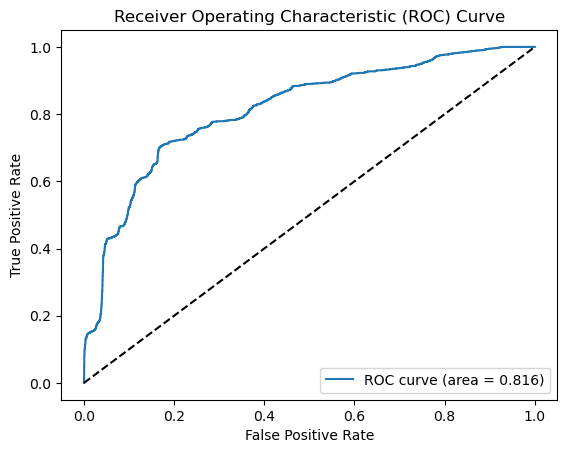

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [65]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

352/352 [==============================] - 1s 3ms/step
Best Threshold=0.088130, Sensitivity=0.744, Specificity=0.691, J=0.435
              precision    recall  f1-score   support

     healthy       0.95      0.69      0.80      9931
     failure       0.24      0.74      0.36      1307

    accuracy                           0.70     11238
   macro avg       0.60      0.72      0.58     11238
weighted avg       0.87      0.70      0.75     11238



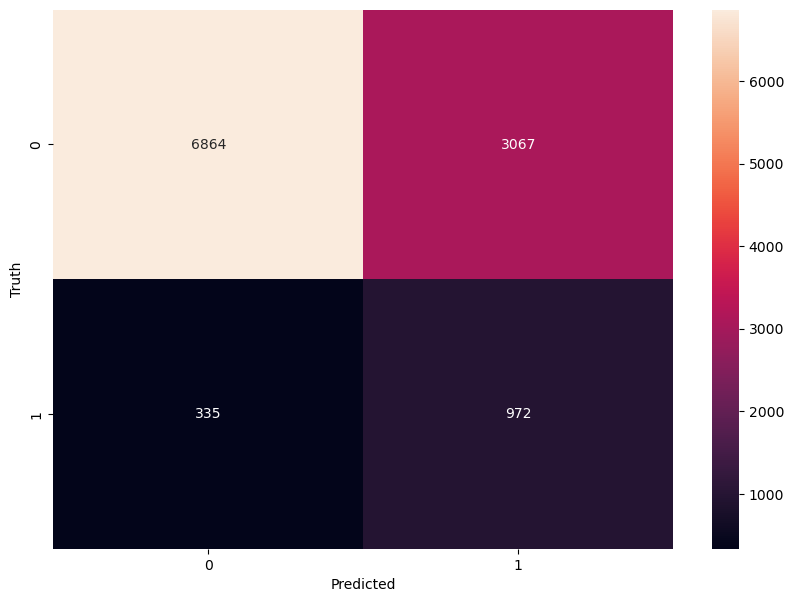

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Conv 1D + LSTM

In [94]:
window_size = 30 # 10일을 window로 설정합니다.
X_train_window, y_train_window = create_sequences(train_scaled, window_size)
X_val_window, y_val_window = create_sequences(val_scaled, window_size)
X_test_window, y_test_window = create_sequences(test_scaled, window_size)

print(X_train_window.shape)
print(X_val_window.shape)
print(X_test_window.shape)

print(y_train_window.shape)
print(y_val_window.shape)
print(y_test_window.shape)


(36698, 30, 32)
(9100, 30, 32)
(11238, 30, 32)
(36698,)
(9100,)
(11238,)


In [95]:
X_train_window = X_train_window.reshape(X_train_window.shape[0], 3, 10, X_train_window.shape[2])
X_val_window = X_val_window.reshape(X_val_window.shape[0], 3, 10, X_val_window.shape[2])
X_test_window = X_test_window.reshape(X_test_window.shape[0], 3, 10, X_test_window.shape[2])

In [96]:
print(X_train_window.shape)
print(X_val_window.shape)
print(X_test_window.shape)

(36698, 3, 10, 32)
(9100, 3, 10, 32)
(11238, 3, 10, 32)


In [91]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout


def Conv1d_LSTM_model():
    # 모델 정의
    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu'), input_shape=(None,10, 32)))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model_cnn_lstm.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu')))
    #model_cnn_lstm.add(TimeDistributed(Dropout(0.5)))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model_cnn_lstm.add(TimeDistributed(Flatten()))
    model_cnn_lstm.add(LSTM(32, activation='relu'))
    model_cnn_lstm.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    #model_cnn_lstm.add(Dropout(0.5))
    model_cnn_lstm.add(Dense(1, activation='sigmoid'))


    # 모델 컴파일
    model_cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model_cnn_lstm

In [92]:
from keras.callbacks import ModelCheckpoint

# ModelCheckpoint 객체 생성
checkpoint = ModelCheckpoint('conv1d_lstm_best_model.h5',  # model filename
                             monitor='val_loss', # property to monitor
                             verbose=1, # verbosity - 0 or 1
                             save_best_only=True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 
model = Conv1d_LSTM_model()

# 학습
history = model.fit(X_train_window, y_train_window, 
                    validation_data=(X_val_window, y_val_window),
                    epochs=20, 
                    verbose=1,
                    batch_size=32,
                    callbacks=[checkpoint])  # checkpoint callback 사용

Epoch 1/20
1143/1147 [============================>.] - ETA: 0s - loss: 0.3448 - accuracy: 0.8854
Epoch 1: val_loss improved from inf to 0.33774, saving model to conv1d_lstm_best_model.h5
1147/1147 [==============================] - 6s 4ms/step - loss: 0.3446 - accuracy: 0.8854 - val_loss: 0.3377 - val_accuracy: 0.8812
Epoch 2/20
  48/1147 [>.............................] - ETA: 3s - loss: 0.3198 - accuracy: 0.8835

c:\Users\choib\anaconda3\envs\iise-python\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1147/1147 [==============================] - ETA: 0s - loss: 0.3135 - accuracy: 0.8875
Epoch 2: val_loss improved from 0.33774 to 0.29742, saving model to conv1d_lstm_best_model.h5
1147/1147 [==============================] - 4s 4ms/step - loss: 0.3135 - accuracy: 0.8875 - val_loss: 0.2974 - val_accuracy: 0.8752
Epoch 3/20
1136/1147 [============================>.] - ETA: 0s - loss: 0.2941 - accuracy: 0.8886
Epoch 3: val_loss did not improve from 0.29742
1147/1147 [==============================] - 5s 4ms/step - loss: 0.2936 - accuracy: 0.8887 - val_loss: 0.3242 - val_accuracy: 0.8712
Epoch 4/20
1138/1147 [============================>.] - ETA: 0s - loss: 0.2771 - accuracy: 0.8897
Epoch 4: val_loss did not improve from 0.29742
1147/1147 [==============================] - 5s 5ms/step - loss: 0.2771 - accuracy: 0.8897 - val_loss: 0.3674 - val_accuracy: 0.8746
Epoch 5/20
1140/1147 [============================>.] - ETA: 0s - loss: 0.2627 - accuracy: 0.8932
Epoch 5: val_loss did not improv

In [97]:
from keras.models import load_model

best_model = Conv1d_LSTM_model()

# 미리 저장한 모델 파일을 불러옵니다.
best_model.load_weights('conv1d_lstm_best_model.h5')

# 모델을 사용하여 예측을 수행합니다.
best_model.evaluate(X_test_window,y_test_window)

352/352 [==============================] - 1s 2ms/step - loss: 0.3040 - accuracy: 0.8837


[0.30399206280708313, 0.8836981654167175]

In [98]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

352/352 [==============================] - 1s 2ms/step
Macro F1 Score: 0.46912938731163495


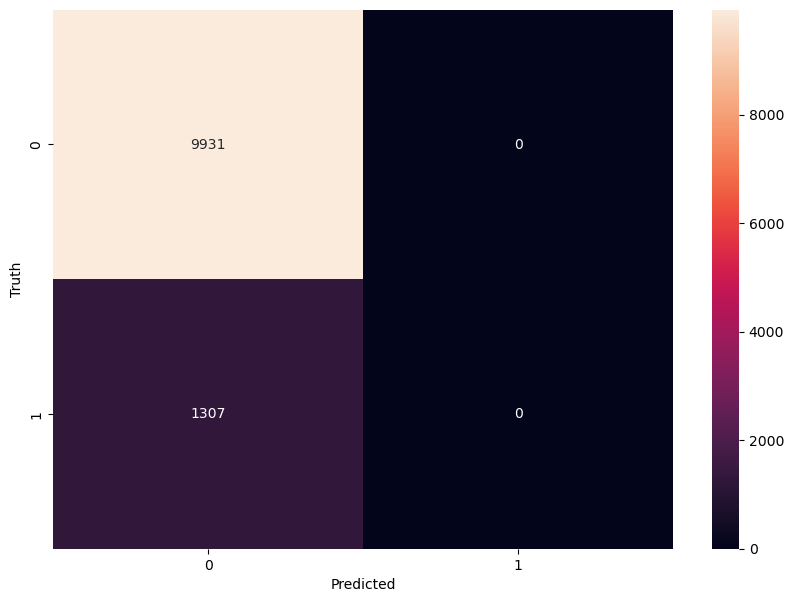

In [99]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [100]:
print(y_test_window.shape)

count_ones = np.count_nonzero(y_test_window == 1)

print("Number of ones in y_test_window:", count_ones)

(11238,)
Number of ones in y_test_window: 1307


352/352 [==============================] - 1s 2ms/step


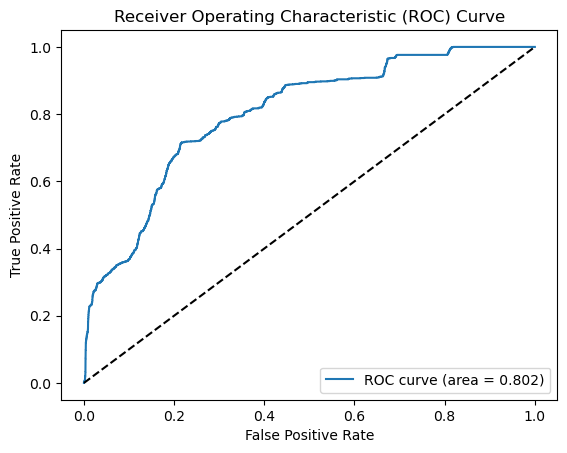

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [102]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = best_model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

352/352 [==============================] - 1s 2ms/step
Best Threshold=0.183468, Sensitivity=0.715, Specificity=0.784, J=0.499
              precision    recall  f1-score   support

     healthy       0.95      0.78      0.86      9931
     failure       0.30      0.71      0.43      1307

    accuracy                           0.78     11238
   macro avg       0.63      0.75      0.64     11238
weighted avg       0.88      0.78      0.81     11238



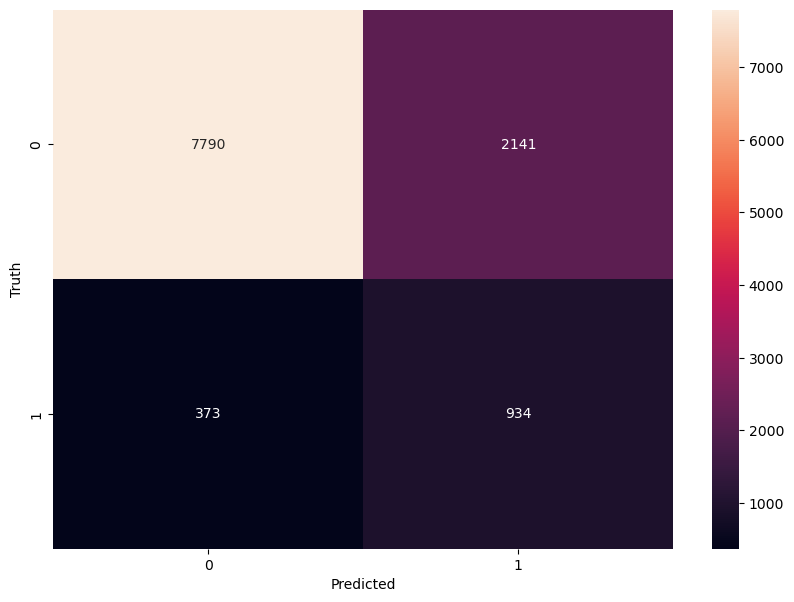

In [103]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## LSTM (window = 90)

In [80]:
window_size = 90 # 10일을 window로 설정합니다.
X_train_window, y_trian_window = create_sequences(train_scaled, window_size)
X_test_window, y_test_window = create_sequences(test_scaled, window_size)

print(X_train_window.shape)
print(X_test_window.shape)

print(y_trian_window.shape)
print(y_test_window.shape)


(23804, 90, 32)
(6031, 90, 32)
(23804,)
(6031,)


In [84]:
# 라이브러리 임포트
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU
from keras import regularizers

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(90, 32)))  # n_features는 특성의 수
model.add(Dense(32, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc'])

# 학습
history = model.fit(X_train_window,y_trian_window, epochs=15, verbose=1,batch_size=32)

Epoch 1/15
744/744 [==============================] - 14s 18ms/step - loss: 0.3737 - acc: 0.8663
Epoch 2/15
744/744 [==============================] - 14s 19ms/step - loss: 0.3403 - acc: 0.8666
Epoch 3/15
744/744 [==============================] - 14s 18ms/step - loss: 0.3346 - acc: 0.8673
Epoch 4/15
744/744 [==============================] - 14s 18ms/step - loss: 0.3993 - acc: 0.8706
Epoch 5/15
744/744 [==============================] - 14s 19ms/step - loss: 0.3420 - acc: 0.8694
Epoch 6/15
744/744 [==============================] - 15s 20ms/step - loss: 665.6763 - acc: 0.8696
Epoch 7/15
744/744 [==============================] - 15s 20ms/step - loss: 0.3299 - acc: 0.8699
Epoch 8/15
744/744 [==============================] - 15s 20ms/step - loss: 0.3287 - acc: 0.8704
Epoch 9/15
744/744 [==============================] - 14s 19ms/step - loss: 0.3250 - acc: 0.8698
Epoch 10/15
744/744 [==============================] - 14s 19ms/step - loss: 0.4041 - acc: 0.8701
Epoch 11/15
744/744 [======

In [85]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 32)                8320      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9,409
Trainable params: 9,409
Non-trainable params: 0
_________________________________________________________________


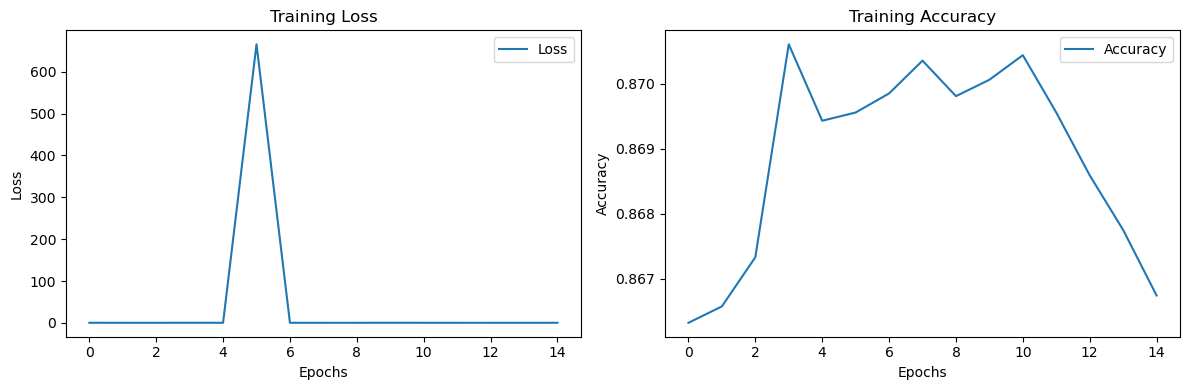

In [86]:
import matplotlib.pyplot as plt

# 훈련 손실과 정확도 그리기
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['acc'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [87]:
model.evaluate(X_test_window,y_test_window)

189/189 [==============================] - 2s 7ms/step - loss: 0.3199 - acc: 0.8647


[0.31993842124938965, 0.8646990656852722]

In [88]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'F1 Score: {f1}')

189/189 [==============================] - 1s 7ms/step
F1 Score: 0.5255740777159515


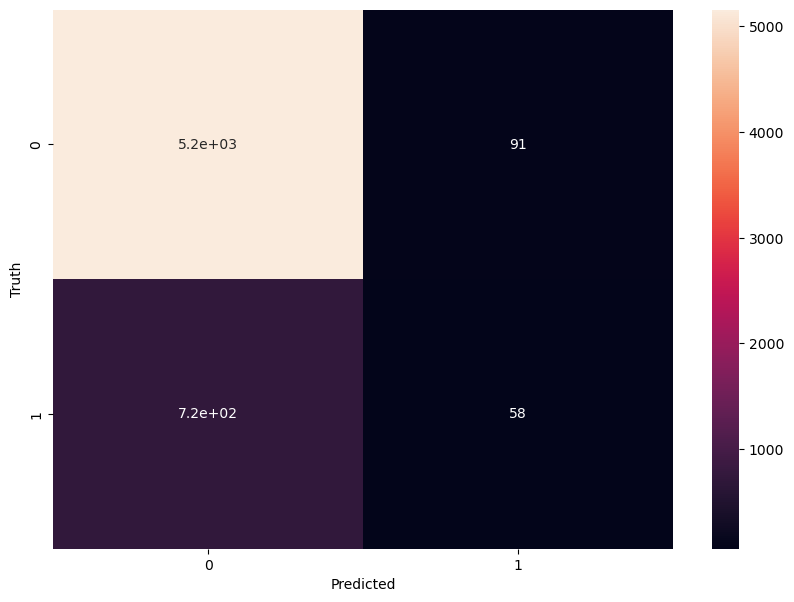

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## LSTM + Attention

In [390]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_val_scaled=scaler.transform(X_val)

# Assuming 'X_train' is the original DataFrame before scaling and its columns are to be preserved
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

train_scaled = pd.concat([train_set[['disk_id','index']],X_train_scaled_df, y_train], axis=1)
val_scaled = pd.concat([val_set[['disk_id','index']],X_val_scaled_df, y_val], axis=1)

In [391]:
window_size = 90 # 10일을 window로 설정합니다.
X_train_window, y_trian_window = create_sequences(train_scaled, window_size)
X_val_window, y_val_window = create_sequences(val_scaled, window_size)

print(X_train_window.shape)
print(X_val_window.shape)

print(y_trian_window.shape)
print(y_val_window.shape)

(19167, 90, 32)
(4637, 90, 32)
(19167,)
(4637,)


In [264]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self, timesteps, **kwargs):
        self.timesteps = timesteps
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(self.timesteps, 1),
                               initializer="zeros")     
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.squeeze(tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b), axis=-1)
        at = tf.keras.backend.softmax(et)
        at = tf.keras.backend.expand_dims(at, axis=-1)
        output = x*at
        return tf.keras.backend.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        base_config = super(Attention, self).get_config()
        base_config.update({"timesteps": self.timesteps})
        return base_config

In [265]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from keras import regularizers

inputs = Input(shape=(90, 32))
lstm_out = LSTM(32, return_sequences=True)(inputs)
attention_out = Attention(90)(lstm_out)
x = Dense(32,  kernel_regularizer=regularizers.l2(0.001))(attention_out)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

In [266]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [267]:
model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 90, 32)]          0         
                                                                 
 lstm_39 (LSTM)              (None, 90, 32)            8320      
                                                                 
 attention_19 (Attention)    (None, 32)                122       
                                                                 
 dense_58 (Dense)            (None, 32)                1056      
                                                                 
 dense_59 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9,531
Trainable params: 9,531
Non-trainable params: 0
_________________________________________________________________


In [268]:
# 학습
history = model.fit(X_train_window,y_trian_window, validation_data=(X_val_window, y_val_window),epochs=10, verbose=1,batch_size=32)

Epoch 1/10
599/599 [==============================] - 18s 27ms/step - loss: 0.3702 - accuracy: 0.8644 - val_loss: 0.3012 - val_accuracy: 0.8866
Epoch 2/10
599/599 [==============================] - 15s 25ms/step - loss: 0.3449 - accuracy: 0.8648 - val_loss: 0.2944 - val_accuracy: 0.8851
Epoch 3/10
599/599 [==============================] - 15s 25ms/step - loss: 0.3350 - accuracy: 0.8644 - val_loss: 0.2949 - val_accuracy: 0.8851
Epoch 4/10
599/599 [==============================] - 14s 24ms/step - loss: 0.3354 - accuracy: 0.8643 - val_loss: 0.2900 - val_accuracy: 0.8866
Epoch 5/10
599/599 [==============================] - 14s 24ms/step - loss: 0.3290 - accuracy: 0.8654 - val_loss: 0.2814 - val_accuracy: 0.8866
Epoch 6/10
599/599 [==============================] - 15s 26ms/step - loss: 0.3309 - accuracy: 0.8663 - val_loss: 0.2920 - val_accuracy: 0.8866
Epoch 7/10
599/599 [==============================] - 16s 27ms/step - loss: 0.3271 - accuracy: 0.8690 - val_loss: 0.2908 - val_accuracy:

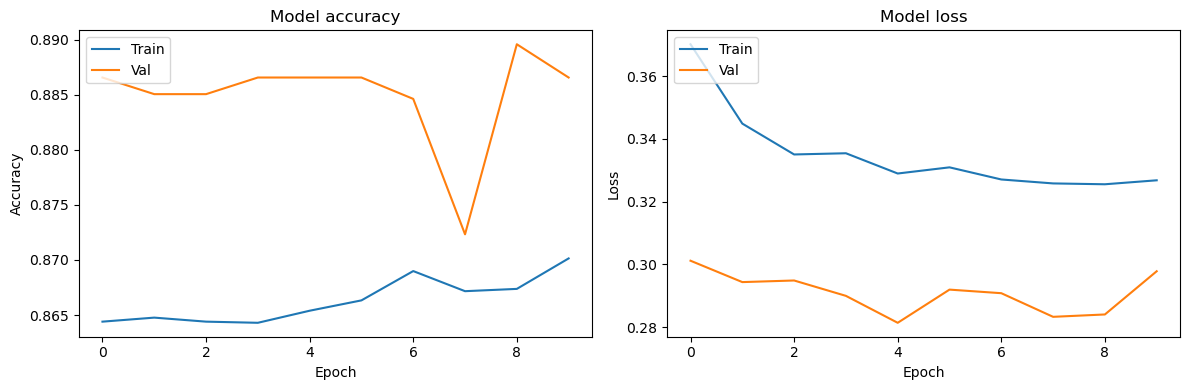

In [269]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

- epoch : 7 에서 최적의 모델 구축가능하다고 판단
- final_X_train(194/194)에 대해서 7 epoch만큼 학습

In [270]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(final_X_train)

final_X_train_scaled=scaler.transform(final_X_train)
X_test_scaled=scaler.transform(X_test)

# Assuming 'final_X_train' is the original DataFrame before scaling and its columns are to be preserved
final_X_train_scaled_df = pd.DataFrame(final_X_train_scaled, columns=final_X_train.columns, index=final_X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

final_train_scaled = pd.concat([final_train_set[['disk_id','index']],final_X_train_scaled_df, final_y_train], axis=1)
test_scaled = pd.concat([test_set[['disk_id','index']],X_test_scaled_df, y_test], axis=1)

In [271]:
window_size = 90 # 10일을 window로 설정합니다.
final_X_train_window, final_y_trian_window = create_sequences(final_train_scaled, window_size)
X_test_window, y_test_window = create_sequences(test_scaled, window_size)

print(final_X_train_window.shape)
print(X_test_window.shape)

print(final_y_trian_window.shape)
print(y_test_window.shape)

(23804, 90, 32)
(6031, 90, 32)
(23804,)
(6031,)


In [304]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from keras import regularizers

inputs = Input(shape=(90, 32))
lstm_out = LSTM(32, return_sequences=True)(inputs)
attention_out = Attention(90)(lstm_out)
x = Dense(32,  kernel_regularizer=regularizers.l2(0.001))(attention_out)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [305]:
# 학습
history = model.fit(final_X_train_window,final_y_trian_window,epochs=5, verbose=1,batch_size=32)

Epoch 1/5
744/744 [==============================] - 19s 22ms/step - loss: 0.3548 - accuracy: 0.8691
Epoch 2/5
744/744 [==============================] - 17s 22ms/step - loss: 0.3505 - accuracy: 0.8684
Epoch 3/5
744/744 [==============================] - 16s 21ms/step - loss: 0.3364 - accuracy: 0.8697
Epoch 4/5
744/744 [==============================] - 18s 24ms/step - loss: 0.3267 - accuracy: 0.8707
Epoch 5/5
744/744 [==============================] - 18s 24ms/step - loss: 0.3262 - accuracy: 0.8688


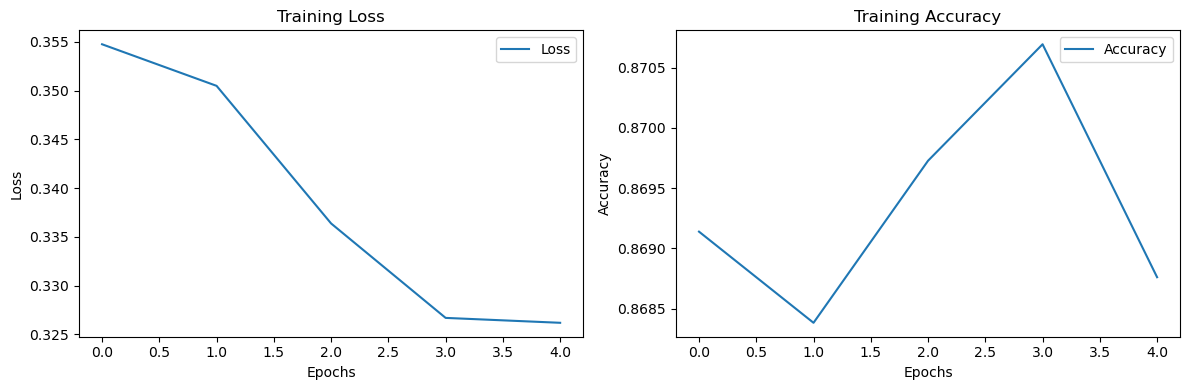

In [306]:
import matplotlib.pyplot as plt

# 훈련 손실과 정확도 그리기
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [307]:
model.evaluate(X_test_window,y_test_window)

189/189 [==============================] - 2s 9ms/step - loss: 0.3128 - accuracy: 0.8725


[0.31281816959381104, 0.8724921345710754]

In [308]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'F1 Score: {f1}')

189/189 [==============================] - 2s 9ms/step
F1 Score: 0.595051016349837


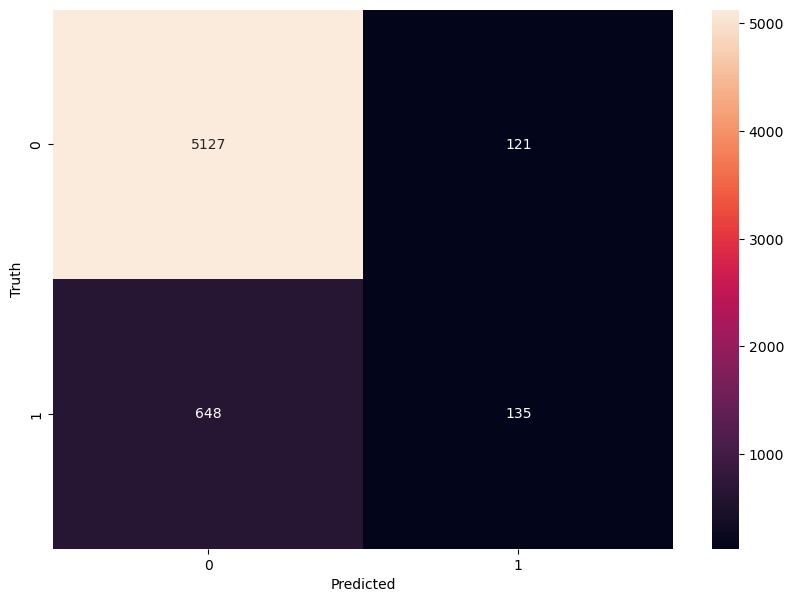

In [309]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

189/189 [==============================] - 2s 9ms/step


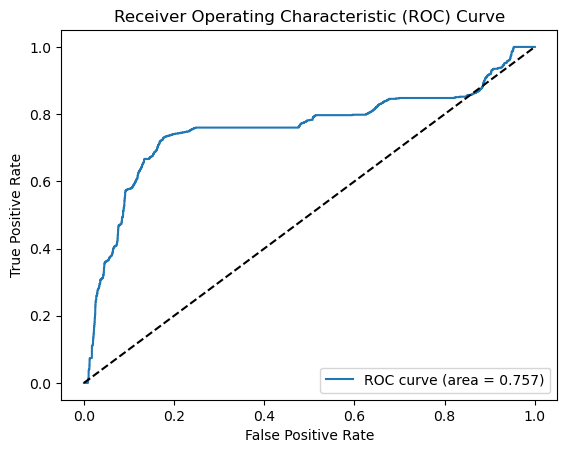

In [310]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [311]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# 이진 분류 문제의 경우, 임계값 0.3으로 설정하여 예측값을 0 또는 1로 변환
y_pred = (y_pred > 0.35).astype(int)

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

189/189 [==============================] - 2s 9ms/step
Macro F1 Score: 0.7100234748423226


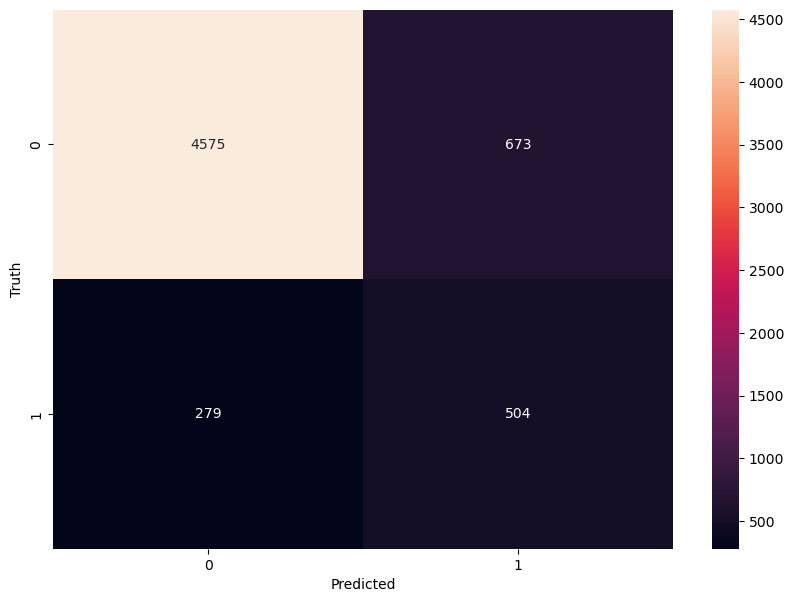

In [312]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [313]:
print(y_test_window.shape)

count_ones = np.count_nonzero(y_test_window == 1)

print("Number of ones in y_test_window:", count_ones)

(6031,)
Number of ones in y_test_window: 783


In [314]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

189/189 [==============================] - 2s 8ms/step
Best Threshold=0.140540, Sensitivity=0.729, Specificity=0.825, J=0.554
              precision    recall  f1-score   support

     healthy       0.95      0.82      0.88      5248
     failure       0.38      0.73      0.50       783

    accuracy                           0.81      6031
   macro avg       0.67      0.78      0.69      6031
weighted avg       0.88      0.81      0.83      6031



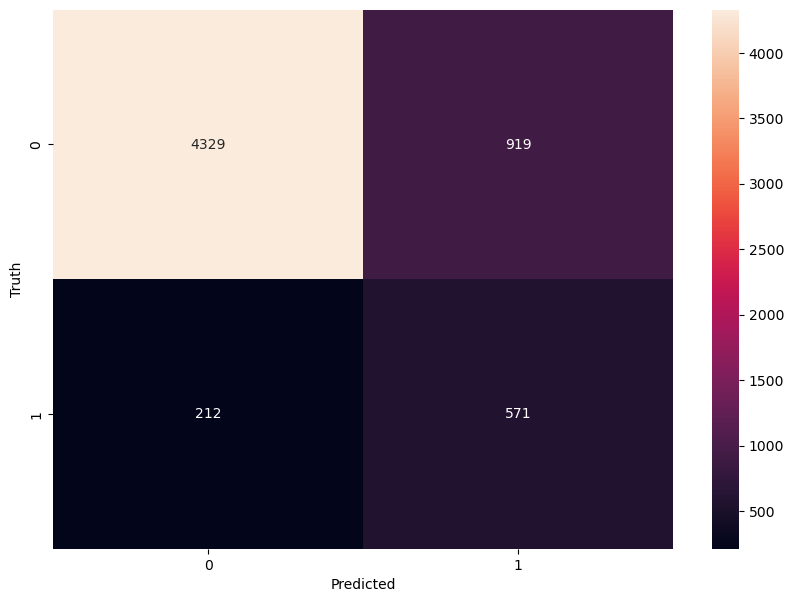

In [315]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## Conv 1d + LSTM + Attention

In [316]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_val_scaled=scaler.transform(X_val)

# Assuming 'X_train' is the original DataFrame before scaling and its columns are to be preserved
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

train_scaled = pd.concat([train_set[['disk_id','index']],X_train_scaled_df, y_train], axis=1)
val_scaled = pd.concat([val_set[['disk_id','index']],X_val_scaled_df, y_val], axis=1)

In [317]:
window_size = 90 # 10일을 window로 설정합니다.
X_train_window, y_trian_window = create_sequences(train_scaled, window_size)
X_val_window, y_val_window = create_sequences(val_scaled, window_size)

print(X_train_window.shape)
print(X_val_window.shape)

print(y_trian_window.shape)
print(y_val_window.shape)

(19167, 90, 32)
(4637, 90, 32)
(19167,)
(4637,)


In [318]:
X_train_window = X_train_window.reshape(X_train_window.shape[0], 3, 30, X_train_window.shape[2])
X_val_window = X_val_window.reshape(X_val_window.shape[0], 3, 30, X_val_window.shape[2])

print(X_train_window.shape)
print(X_val_window.shape)

(19167, 3, 30, 32)
(4637, 3, 30, 32)


In [319]:
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self, timesteps, **kwargs):
        self.timesteps = timesteps
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(self.timesteps, 1),
                               initializer="zeros")     
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = tf.keras.backend.squeeze(tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b), axis=-1)
        at = tf.keras.backend.softmax(et)
        at = tf.keras.backend.expand_dims(at, axis=-1)
        output = x*at
        return tf.keras.backend.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        base_config = super(Attention, self).get_config()
        base_config.update({"timesteps": self.timesteps})
        return base_config

In [320]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from keras import regularizers

# 모델 정의input_shape=(None,30, 32)
inputs = Input(shape=(None, 30, 32))
x = TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu'))(inputs)
x = TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'))(x)
#x = TimeDistributed(Dropout(0.5))
x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = TimeDistributed(Flatten())(x)
lstm_out = LSTM(32, return_sequences=True)(x)
attention_out = Attention(3)(lstm_out)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(attention_out)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [321]:
model.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, None, 30, 32)]    0         
                                                                 
 time_distributed_104 (TimeD  (None, None, 28, 16)     1552      
 istributed)                                                     
                                                                 
 time_distributed_105 (TimeD  (None, None, 26, 32)     1568      
 istributed)                                                     
                                                                 
 time_distributed_106 (TimeD  (None, None, 13, 32)     0         
 istributed)                                                     
                                                                 
 time_distributed_107 (TimeD  (None, None, 416)        0         
 istributed)                                              

In [322]:
# 학습
history = model.fit(X_train_window,y_trian_window, validation_data=(X_val_window, y_val_window),epochs=20, verbose=1,batch_size=32)

Epoch 1/20
599/599 [==============================] - 9s 11ms/step - loss: 0.3672 - accuracy: 0.8640 - val_loss: 0.3104 - val_accuracy: 0.8866
Epoch 2/20
599/599 [==============================] - 7s 11ms/step - loss: 0.3377 - accuracy: 0.8655 - val_loss: 0.2917 - val_accuracy: 0.8866
Epoch 3/20
599/599 [==============================] - 7s 11ms/step - loss: 0.3306 - accuracy: 0.8655 - val_loss: 0.2872 - val_accuracy: 0.8866
Epoch 4/20
599/599 [==============================] - 7s 11ms/step - loss: 0.3244 - accuracy: 0.8675 - val_loss: 0.2916 - val_accuracy: 0.8844
Epoch 5/20
599/599 [==============================] - 7s 11ms/step - loss: 0.3237 - accuracy: 0.8698 - val_loss: 0.2785 - val_accuracy: 0.8872
Epoch 6/20
599/599 [==============================] - 7s 11ms/step - loss: 0.3127 - accuracy: 0.8794 - val_loss: 0.2756 - val_accuracy: 0.8831
Epoch 7/20
599/599 [==============================] - 7s 11ms/step - loss: 0.3074 - accuracy: 0.8847 - val_loss: 0.2844 - val_accuracy: 0.8859

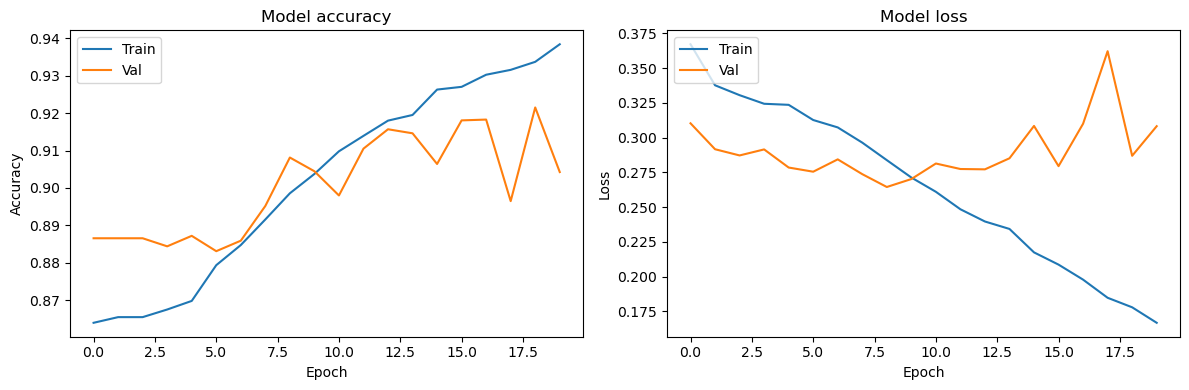

In [323]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

10에폭 0.2525 / 15에폭 0.2528
- 10에폭으로 해보자~

In [324]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(final_X_train)

final_X_train_scaled=scaler.transform(final_X_train)
X_test_scaled=scaler.transform(X_test)

# Assuming 'final_X_train' is the original DataFrame before scaling and its columns are to be preserved
final_X_train_scaled_df = pd.DataFrame(final_X_train_scaled, columns=final_X_train.columns, index=final_X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

final_train_scaled = pd.concat([final_train_set[['disk_id','index']],final_X_train_scaled_df, final_y_train], axis=1)
test_scaled = pd.concat([test_set[['disk_id','index']],X_test_scaled_df, y_test], axis=1)

In [325]:
window_size = 90 # 10일을 window로 설정합니다.
final_X_train_window, final_y_trian_window = create_sequences(final_train_scaled, window_size)
X_test_window, y_test_window = create_sequences(test_scaled, window_size)

print(final_X_train_window.shape)
print(X_test_window.shape)

print(final_y_trian_window.shape)
print(y_test_window.shape)

(23804, 90, 32)
(6031, 90, 32)
(23804,)
(6031,)


In [326]:
final_X_train_window = final_X_train_window.reshape(final_X_train_window.shape[0], 3, 30, final_X_train_window.shape[2])
X_test_window = X_test_window.reshape(X_test_window.shape[0], 3, 30, X_test_window.shape[2])

print(final_X_train_window.shape)
print(X_test_window.shape)

(23804, 3, 30, 32)
(6031, 3, 30, 32)


In [328]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from keras import regularizers

# 모델 정의input_shape=(None,30, 32)
inputs = Input(shape=(None, 30, 32))
x = TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu'))(inputs)
x = TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'))(x)
#x = TimeDistributed(Dropout(0.5))
x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = TimeDistributed(Flatten())(x)
lstm_out = LSTM(32, return_sequences=True)(x)
attention_out = Attention(3)(lstm_out)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(attention_out)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# 학습
history = model.fit(final_X_train_window,final_y_trian_window,epochs=9, verbose=1,batch_size=32)

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, None, 30, 32)]    0         
                                                                 
 time_distributed_112 (TimeD  (None, None, 28, 16)     1552      
 istributed)                                                     
                                                                 
 time_distributed_113 (TimeD  (None, None, 26, 32)     1568      
 istributed)                                                     
                                                                 
 time_distributed_114 (TimeD  (None, None, 13, 32)     0         
 istributed)                                                     
                                                                 
 time_distributed_115 (TimeD  (None, None, 416)        0         
 istributed)                                              

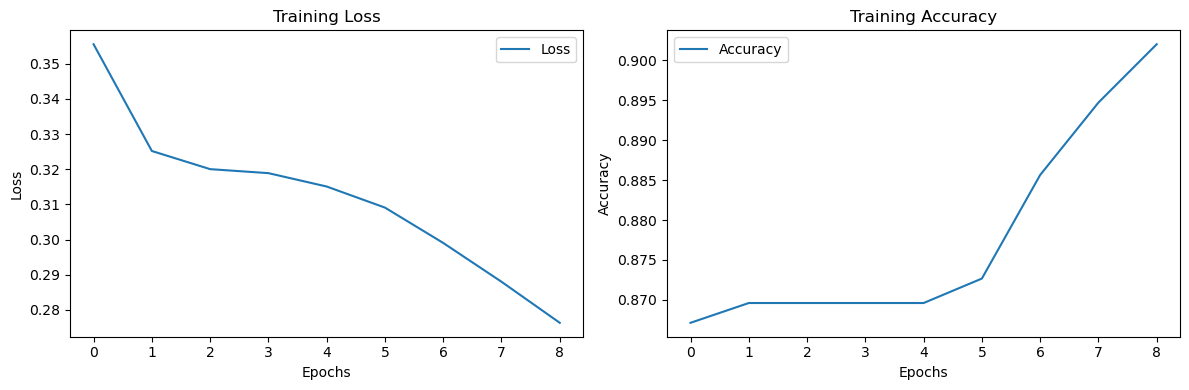

In [329]:
import matplotlib.pyplot as plt

# 훈련 손실과 정확도 그리기
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [330]:
model.evaluate(X_test_window,y_test_window)

189/189 [==============================] - 1s 4ms/step - loss: 0.2804 - accuracy: 0.8843


[0.28040024638175964, 0.8842646479606628]

In [331]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.
y_pred = np.round(y_pred) # 이진 분류 문제의 경우, 출력값을 반올림하여 0 또는 1로 변환

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'F1 Score: {f1}')

189/189 [==============================] - 1s 4ms/step
F1 Score: 0.7122479184370751


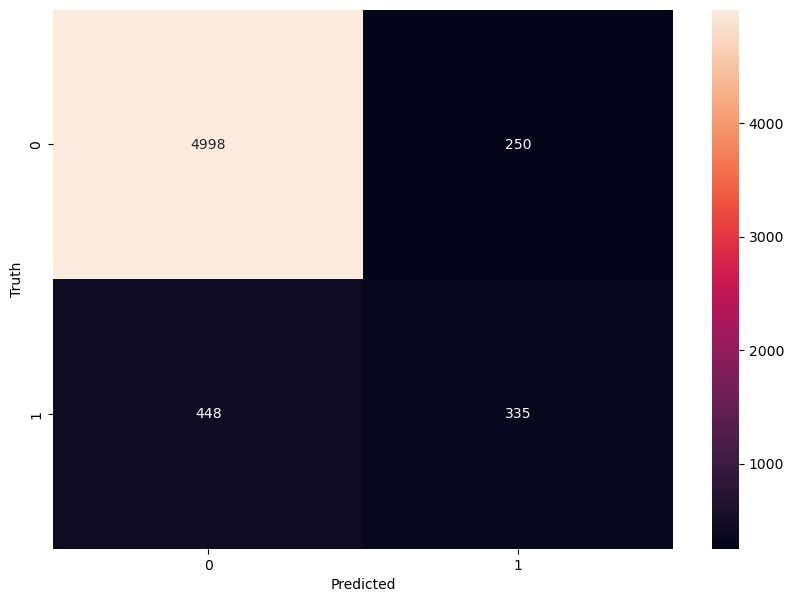

In [332]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

189/189 [==============================] - 1s 4ms/step


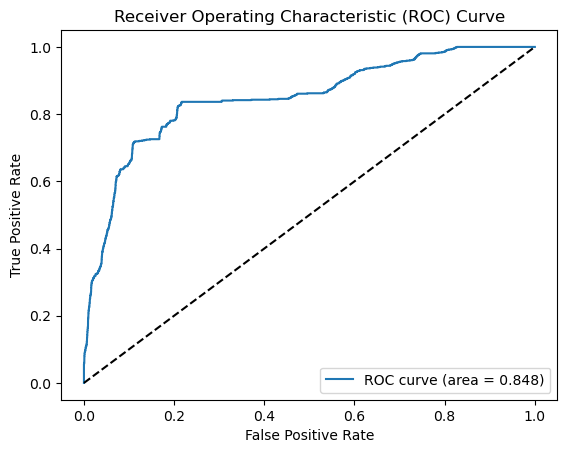

In [333]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [342]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# 이진 분류 문제의 경우, 임계값 0.3으로 설정하여 예측값을 0 또는 1로 변환
y_pred = (y_pred > 0.35).astype(int)

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

189/189 [==============================] - 1s 4ms/step
Macro F1 Score: 0.7448160489833261


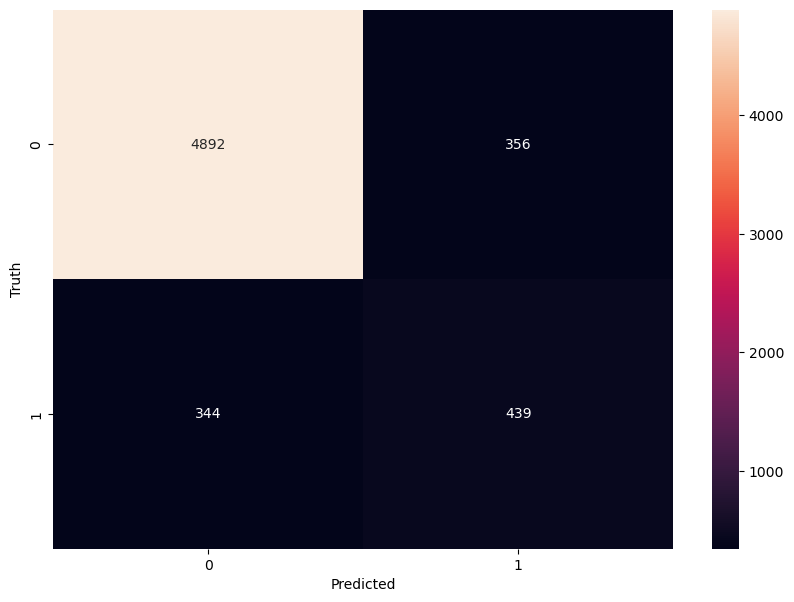

In [343]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [336]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

189/189 [==============================] - 1s 4ms/step
Best Threshold=0.070733, Sensitivity=0.837, Specificity=0.783, J=0.620
              precision    recall  f1-score   support

     healthy       0.97      0.78      0.87      5248
     failure       0.37      0.84      0.51       783

    accuracy                           0.79      6031
   macro avg       0.67      0.81      0.69      6031
weighted avg       0.89      0.79      0.82      6031



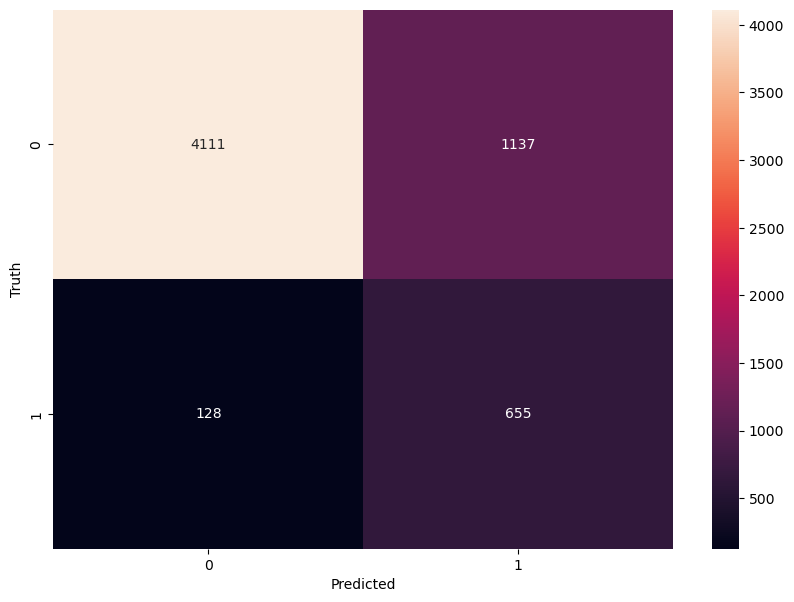

In [337]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## CNN + LSTM + SelfAttention? 만드는중,,,

In [359]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
from keras import regularizers

inputs = Input(shape=(None, 30, 32))
x = TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu'))(inputs)
x = TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'))(x)
x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = TimeDistributed(Flatten())(x)
lstm_out = LSTM(32, return_sequences=True)(x)
attention_out = MultiHeadAttention(num_heads=10, key_dim=2)(lstm_out, lstm_out)
x = TimeDistributed(Dense(32, activation='relu'))(x)
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [360]:
model.summary()

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, None, 30, 32)]    0         
                                                                 
 time_distributed_121 (TimeD  (None, None, 28, 16)     1552      
 istributed)                                                     
                                                                 
 time_distributed_122 (TimeD  (None, None, 26, 32)     1568      
 istributed)                                                     
                                                                 
 time_distributed_123 (TimeD  (None, None, 13, 32)     0         
 istributed)                                                     
                                                                 
 time_distributed_124 (TimeD  (None, None, 416)        0         
 istributed)                                              

In [361]:
# 학습
history = model.fit(final_X_train_window,final_y_trian_window,epochs=10, verbose=1,batch_size=32)

Epoch 1/10
744/744 [==============================] - 5s 6ms/step - loss: 0.3456 - accuracy: 0.8691
Epoch 2/10
744/744 [==============================] - 4s 6ms/step - loss: 0.3272 - accuracy: 0.8691
Epoch 3/10
744/744 [==============================] - 4s 6ms/step - loss: 0.3217 - accuracy: 0.8686
Epoch 4/10
744/744 [==============================] - 4s 6ms/step - loss: 0.3158 - accuracy: 0.8691
Epoch 5/10
744/744 [==============================] - 4s 5ms/step - loss: 0.3119 - accuracy: 0.8691
Epoch 6/10
744/744 [==============================] - 4s 5ms/step - loss: 0.3036 - accuracy: 0.8727
Epoch 7/10
744/744 [==============================] - 4s 5ms/step - loss: 0.2971 - accuracy: 0.8719
Epoch 8/10
744/744 [==============================] - 4s 5ms/step - loss: 0.2907 - accuracy: 0.8751
Epoch 9/10
744/744 [==============================] - 4s 6ms/step - loss: 0.2804 - accuracy: 0.8790
Epoch 10/10
744/744 [==============================] - 4s 6ms/step - loss: 0.2746 - accuracy: 0.8843

189/189 [==============================] - 0s 2ms/step


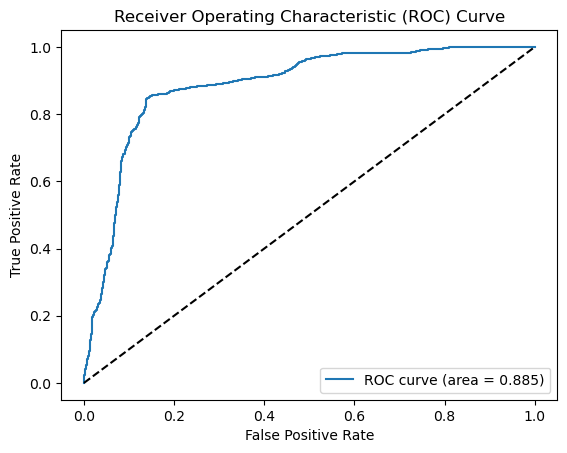

In [362]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 커브를 그리기 위한 점들을 출력합니다.
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # 기준선 (diagonal)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [363]:
from sklearn.metrics import f1_score

# 테스트 데이터셋을 사용하여 예측 수행
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# 이진 분류 문제의 경우, 임계값 0.1으로 설정하여 예측값을 0 또는 1로 변환
y_pred = (y_pred > 0.1).astype(int)

# f1 score 계산
f1 = f1_score(y_test_window, y_pred, average='macro') # y_test_window는 테스트 데이터셋의 실제 레이블이어야 합니다.

print(f'Macro F1 Score: {f1}')

189/189 [==============================] - 0s 2ms/step
Macro F1 Score: 0.7585713682177979


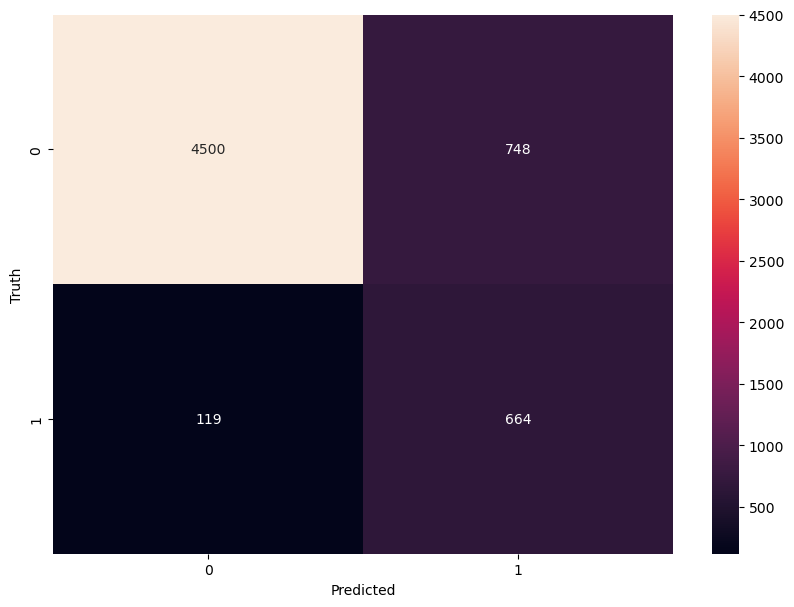

In [364]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [365]:
from numpy import argmax
from sklearn.metrics import roc_curve, classification_report

# 예측 확률 계산
y_pred = model.predict(X_test_window) # X_test_window는 테스트 데이터셋의 입력 특성이어야 합니다.

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_test_window, y_pred)

# Youden's J 통계를 사용하여 최적의 임계값 찾기
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f, Sensitivity=%.3f, Specificity=%.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

# 최적의 임계값을 사용하여 예측 수행
y_pred_class = (y_pred >= best_thresh).astype('int')

# 분류 보고서 출력
print(classification_report(y_test_window, y_pred_class, target_names=['healthy', 'failure']))

189/189 [==============================] - 0s 2ms/step
Best Threshold=0.103824, Sensitivity=0.845, Specificity=0.862, J=0.708
              precision    recall  f1-score   support

     healthy       0.97      0.86      0.91      5248
     failure       0.48      0.85      0.61       783

    accuracy                           0.86      6031
   macro avg       0.73      0.85      0.76      6031
weighted avg       0.91      0.86      0.88      6031



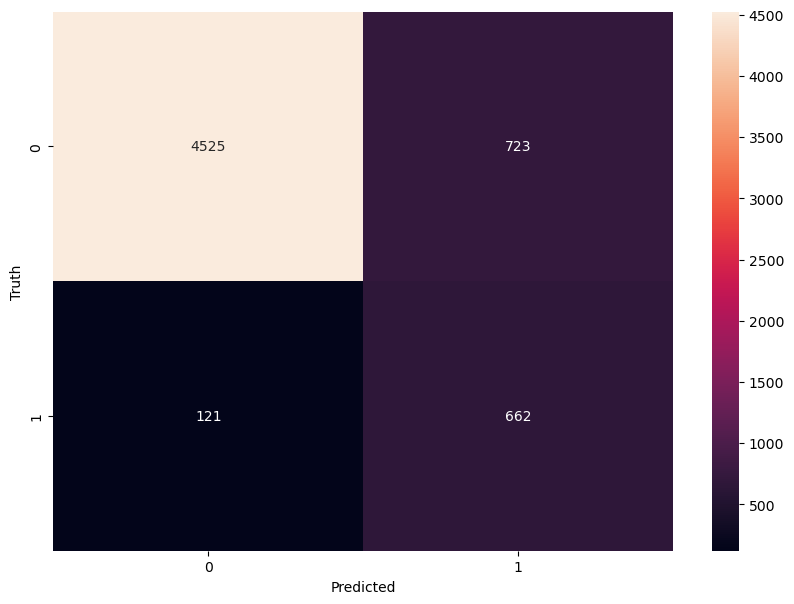

In [369]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_window, y_pred_class)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [387]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, TimeDistributed, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention
from keras import regularizers

inputs = Input(shape=(None, 30, 32))
x = TimeDistributed(Conv1D(filters=16, kernel_size=3, activation='relu'))(inputs)
x = TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'))(x)
x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
x = TimeDistributed(Flatten())(x)
lstm_out = LSTM(32, return_sequences=True)(x)
attention_out, attn_weights = MultiHeadAttention(num_heads=10, key_dim=2, return_attention_scores=True)(lstm_out, lstm_out)
x = TimeDistributed(Dense(32, activation='relu'))(attention_out)
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
outputs = Dense(1, activation='sigmoid')(x)

mulheadatt_model = Model(inputs=inputs, outputs=[outputs, attn_weights])

mulheadatt_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

TypeError: ('Keyword argument not understood:', 'return_attention_scores')